# Image classification of dog breeds

This project outlines a pipeline for an image classification engine. As a POC this engine detects the breed of a dog given an image.

The deployment is done using sagemaker infrastructure kernel = conda_amazonei_pytorch_latest_p36.

In [4]:
import sagemaker
import boto3
import urllib
import zipfile
import os
import matplotlib.pyplot as plt
from IPython.display import Image as ipythonImage
from PIL import Image
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

[2022-02-16 08:37:10.316 ip-172-16-60-229:459 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
Getting data and making it avaiable in s3

In [3]:
#download the data for classification
urllib.request.urlretrieve("https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip", "dogImages.zip")

('dogImages.zip', <http.client.HTTPMessage at 0x7fbc93f28e80>)

In [4]:
import zipfile
with zipfile.ZipFile("dogImages.zip", 'r') as zip_ref:
    zip_ref.extractall("")


The dataset contains a selection of dog picures divided into 133 breeds. We can see their distribution in the graph below

In [5]:
dog_breeds = os.listdir('dogImages/train')
breed_count = []
for breed in dog_breeds:
    breed_count.append(len(os.listdir(os.path.join('dogImages/train',breed))))

<BarContainer object of 133 artists>

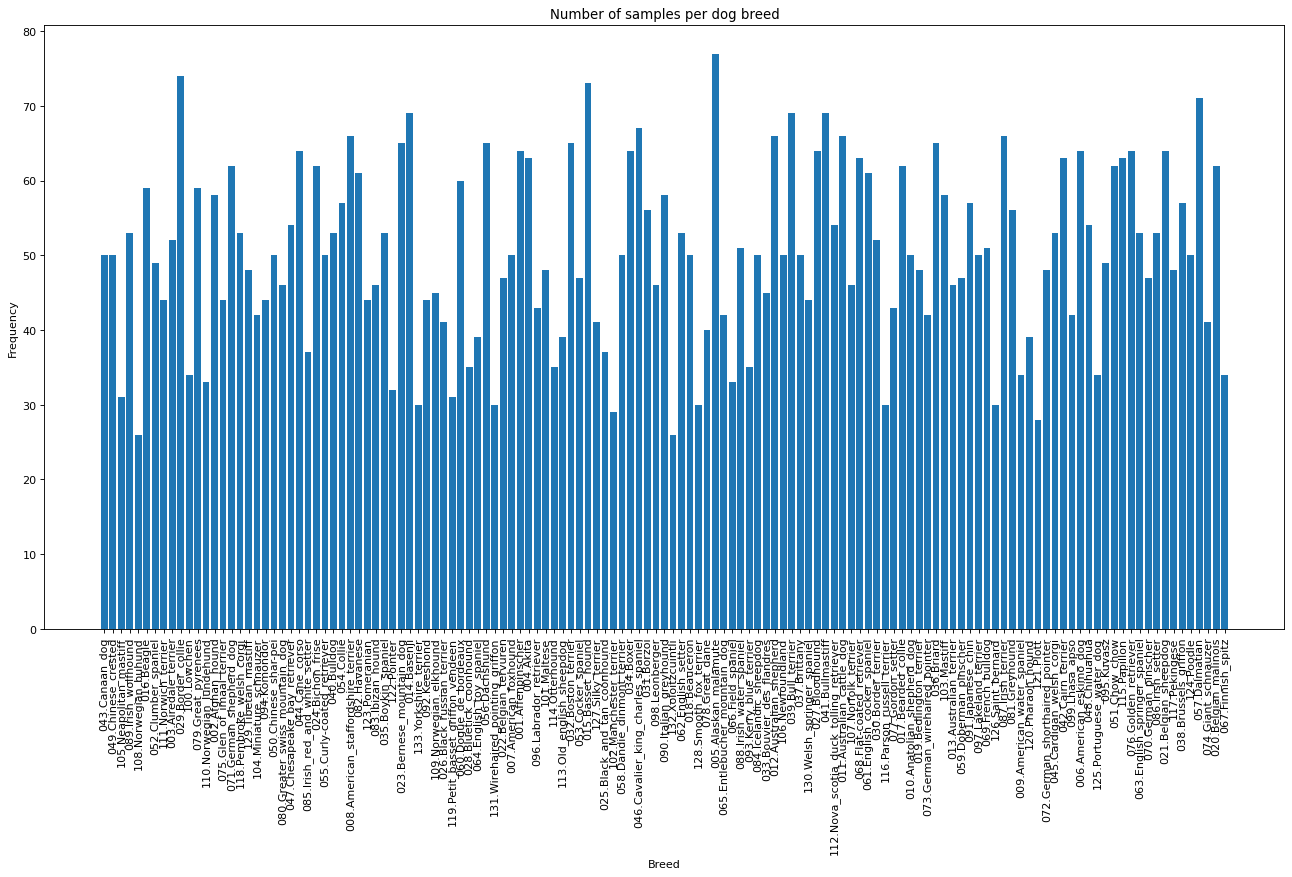

In [6]:
plt.figure(figsize=(20, 10), dpi=80)
plt.xticks(rotation='vertical')
plt.title("Number of samples per dog breed")
plt.xlabel('Breed')
plt.ylabel('Frequency')
plt.bar(dog_breeds,breed_count)

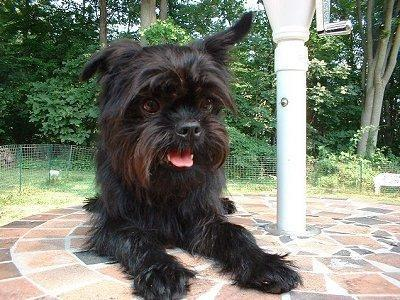

In [9]:
#Sample image
ipythonImage(filename='dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg') 

In [10]:
#uploading the data into S3
from sagemaker import Session
session = Session()
bucket= session.default_bucket()

In [47]:
os.environ["DEFAULT_S3_BUCKET"] = 'operations-ml-project'
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/

upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-ap-northeast-1-985768962182/dogImages/test/001.

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [20]:
#hyperparameter search space
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128])
}

In [5]:
role = sagemaker.get_execution_role()

In [22]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [28]:
os.environ['SM_CHANNEL_TRAINING']='s3://operations-ml-project/'
os.environ['SM_MODEL_DIR']='s3://operations-ml-project/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://operations-ml-project/output/'

tuner.fit({"training": "s3://operations-ml-project/"})

...............................................................................................................................................................................................................................................................................................................................................................!


In [29]:
best_estimator = tuner.best_estimator()


2022-02-16 06:16:39 Starting - Preparing the instances for training
2022-02-16 06:16:39 Downloading - Downloading input data
2022-02-16 06:16:39 Training - Training image download completed. Training in progress.
2022-02-16 06:16:39 Uploading - Uploading generated training model
2022-02-16 06:16:39 Completed - Training job completed


In [30]:
best_hyper = best_estimator.hyperparameters()

In [31]:
best_hyper

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.002092665253964378',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-02-16-05-55-20-610"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-northeast-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-northeast-1-985768962182/pytorch_dog_hpo-2022-02-16-05-55-20-610/source/sourcedir.tar.gz"'}

In [2]:
#taking the best hyperparameter
best_hyper = {"batch_size": '32', "learning_rate": '0.002092665253964378'}

## Model Profiling and Debugging

In [7]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})


In [8]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyper,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [10]:
estimator.fit({"training": "s3://operations-ml-project/"},wait=True)

2022-02-16 08:51:01 Starting - Starting the training job...
2022-02-16 08:51:25 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-02-16 08:52:46 Downloading - Downloading input data.........
2022-02-16 08:54:26 Training - Downloading the training image.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-16 08:57:13,785 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-16 08:57:13,807 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-16 08:57:13,815 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-16 08:57:14,330 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},

In [11]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-16 09:36:17.467 ip-172-16-60-229:459 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-16-08-51-00-950/debug-output


In [12]:
trial.tensor_names()

[2022-02-16 09:36:19.290 ip-172-16-60-229:459 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-16 09:36:20.313 ip-172-16-60-229:459 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [14]:
from mpl_toolkits.axes_grid1 import host_subplot
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


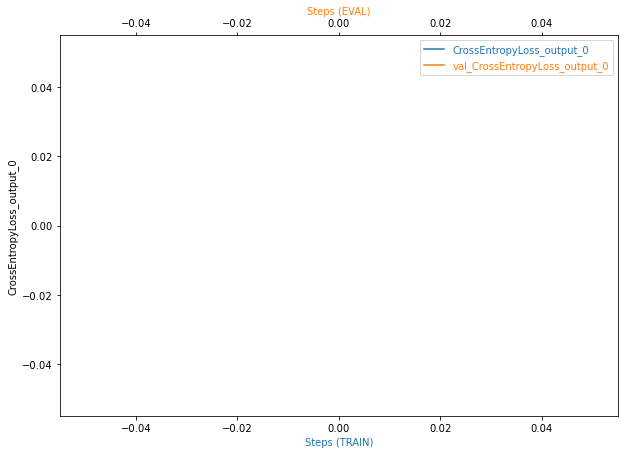

In [15]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [16]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [17]:
! aws s3 ls {rule_output_path} --recursive

2022-02-16 09:22:56     399922 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-16 09:22:55     261285 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-16 09:22:51        192 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-16 09:22:51     119035 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-16 09:22:51       1964 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-16 09:22:51        130 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-16 09:22:51       4867 pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-ap-northeast-1-985768962182/pytorch-training-2022-02-16-08-51-00-950/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-ap-no

In [19]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [20]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [21]:
predictor=estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large') 

------!

In [30]:
import requests
import json

In [27]:
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }
img_bytes = requests.get(request_dict['url']).content

bytes

In [29]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://ap-northeast-1.console.aws.amazon.com/cloudwatch/home?region=ap-northeast-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-02-16-09-37-32-118 in account 985768962182 for more information.

In [ ]:
predictor.delete_endpoint()